# State Estimation, Forward-Backward

In this demo, the goal is to perform state-estimation from noisy observation through forward-backward message passing on a generative state-space model (SSM). We will use the same model as in the previous demo.

\begin{align*}
    u &= 1\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u\\
    y_t &= x_t + n_t
\end{align*}

We further assume that the observations are corrupted by i.i.d. Gaussian noise with variance `v`. 

The SSM can be represented as a Forney-style factor graph, where the pictured section is chained over time:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

In contrast to the previous demo, we will explicitly built the full generative model for the data.

We start by generating some data, and again step through the build-schedule-infer paradigm.

In [1]:
# Data
n_samples = 100
x_data = [t for t=1:n_samples] # True state
y_data = x_data + sqrt(200.0)*randn(n_samples); # Noisy observations of state

# Build

During the build phase, we use `Variable` objects as Julia variables. This allows us to use flow operations, such as `for` and `if` during model construction.

The data are stored in a vector `y_data`. In order to simplify the data assimilation for batch estimation, the `placeholder()` function accepts an `index` argument. This index specifies which datum from the data vector corresponds with the argument variable. During the infer phase, this allows us to simply pass the data vector in its entirety to the `:y` field in the data dictionary.

In [2]:
using ForneyLab

g = FactorGraph()

# Prior statistics
m_x_0 = Variable(id=:m_x_0)
v_x_0 = Variable(id=:v_x_0)

# State prior
x_0 ~ GaussianMeanVariance(m_x_0, v_x_0)

# Transition and observation model
x = Vector{Variable}(n_samples)
y = Vector{Variable}(n_samples)

x_t_min = x_0
for t = 1:n_samples
    u_t = constant(1.0)
    n_t ~ GaussianMeanVariance(constant(0.0), constant(200.0)) # zero-mean gaussian observation noise
    x[t] = x_t_min + u_t
    y[t] = x[t] + n_t

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end

# Placeholders for prior statistics
placeholder(m_x_0, :m_x_0)
placeholder(v_x_0, :v_x_0)

# Name variable for ease of lookup
for t = 1:n_samples
    x[t].id = :x_*t
    y[t].id = :y_*t    
end

# Schedule

The schedule phase comprises of just one line of code. The resulting inference program will be quite long because we chose to build the entire model, but it can still be inspected.

In [3]:
algo = sumProductAlgorithm(x);

# println(algo)

# Infer

Relative to the previous demo, batch inference is much simpler because we do not explicitly need to pass the posterior statistics to the prior; the schedule takes care of the forward and backward pass over time sections.

In [4]:
# Define algorithm
eval(parse(algo))

# Prepare data dictionary and prior statistisc
data = Dict(:y     => y_data,
            :m_x_0 => 0.0,
            :v_x_0 => 1000.0)

# Execute algorithm
marginals = step!(data)

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples];

# Results

Compared to the previous demo (forward-only), the state estimation algorithm in this demo also passes messages backward in time. Therefore, the estimated state will be smoother than the filtering result of the previous demo.

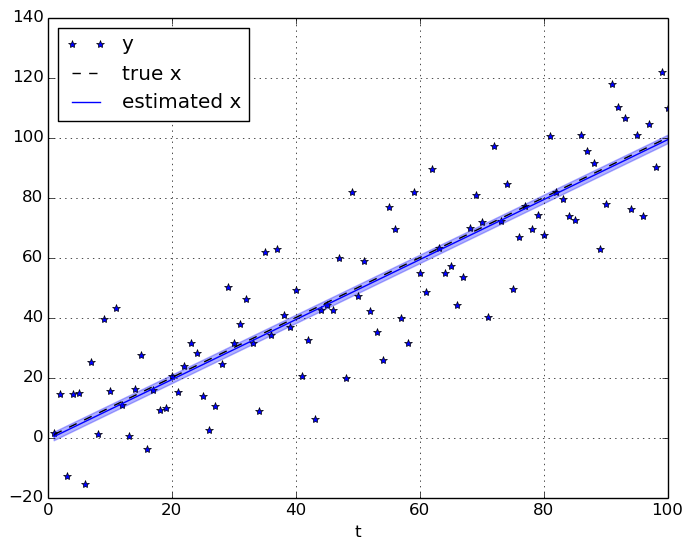

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [5]:
using PyPlot

plot(collect(1:n_samples), y_data, "b*", label="y")
plot(collect(1:n_samples), x_data, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt(v_x), m_x+sqrt(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");